In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv("../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
age = pd.read_csv("../../data/dacon_parking_demand_dataset/age_gender_info.csv")
rent_deposit = pd.read_csv("predicted_rent_deposit.csv")

In [3]:
train.shape, test.shape, rent_deposit.shape

((2952, 15), (1022, 14), (767, 2))

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 지역별 평균 값으로 치환
train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [15]:
train_df.index

Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
            ...
            2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951],
           dtype='int64', length=2869)

In [16]:
test_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021],
           dtype='int64', length=1008)

In [17]:
train_df[train_df["임대보증금"] == 0].index

Int64Index([  88,   89,   90,   91,  101,  102,  103,  104,  105,  106,
            ...
            2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907, 2908],
           dtype='int64', length=581)

In [18]:
test_df[test_df["임대보증금"] == 0].index

Int64Index([  76,   77,   79,   80,   81,   82,   83,   84,   85,   86,
            ...
             329,  330,  331,  332, 1005, 1006, 1014, 1015, 1016, 1017],
           dtype='int64', length=186)

In [19]:
rent_deposit.iloc[581]

index          76.0
임대보증금    11258525.0
Name: 581, dtype: float64

In [20]:
train_rent_deposit = rent_deposit.iloc[:581]
test_rent_deposit = rent_deposit.iloc[581:]

In [21]:
train_rent_deposit = train_rent_deposit.set_index("index")
test_rent_deposit = test_rent_deposit.set_index("index")

In [22]:
train_df.loc[train_rent_deposit.index, "임대보증금"] = train_rent_deposit["임대보증금"]
test_df.loc[test_rent_deposit.index, "임대보증금"] = test_rent_deposit["임대보증금"]

In [23]:
train_df.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                             0
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [24]:
test_df.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                             0
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

<AxesSubplot:>

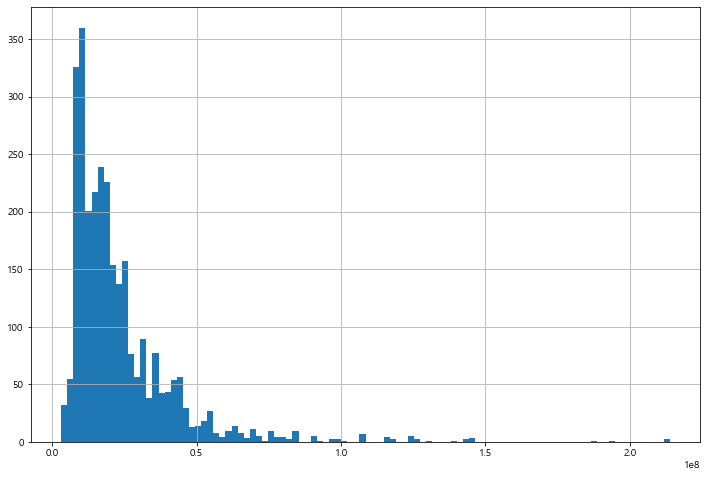

In [25]:
train_df["임대보증금"].hist(bins=100, figsize=(12, 8))

In [26]:
train_df["임대보증금"].value_counts()

24775000.0    22
14418000.0    21
9364600.0     20
5787000.0     18
18726000.0    17
              ..
10164325.0     1
10286050.0     1
13155000.0     1
8625000.0      1
22043000.0     1
Name: 임대보증금, Length: 1098, dtype: int64

In [27]:
train_df["임대보증금"].skew()

3.36460878202262

In [28]:
train_df["임대보증금"].kurt()

18.758347504146197

In [29]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [30]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [31]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [32]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [33]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [34]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

In [35]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [36]:
train_df[train_df["단지코드"] == "C1039"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000.0,...,0,0,0,0,0,0,0,0,0,0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000.0,...,0,0,0,0,0,0,0,0,0,0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [38]:
# 전용 면적 피처를 5의 배수로 전처리, 전후로 비교해서 (103.69 -> 102.80까지 떨어짐)
train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [39]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [40]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [41]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [42]:
train_df["공급유형"].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공분양            7
공공임대(분납)        7
공공임대(5년)        3
장기전세            3
Name: 공급유형, dtype: int64

In [43]:
train_df[train_df["공급유형"] == "장기전세"]

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적,전용면적 당 차량등록수
2100,C1039,790,서울특별시,장기전세,50.0,126,13.0,A,187694000.0,-,...,0,0,0,0,0,0,1,6300.0,33080.0,122.838573
2101,C1039,790,서울특별시,장기전세,55.0,49,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,2695.0,33080.0,52.547612
2102,C1039,790,서울특별시,장기전세,55.0,75,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,4125.0,33080.0,80.430018


In [44]:
test_df["공급유형"].value_counts() # 테스트 셋에는 없는 공급유형 -> 공공분양, 공공임대(5년), 장기전세

국민임대         614
임대상가         177
행복주택         120
영구임대          43
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [45]:
supply_qualification_df = pd.get_dummies(train_df["공급유형"])
train_df = pd.concat([train_df, supply_qualification_df], axis=1)

supply_qualification_df = pd.get_dummies(test_df["공급유형"])
test_df = pd.concat([test_df, supply_qualification_df], axis=1)
test_df["공공임대(5년)"] = 0
test_df["공공분양"] = 0
test_df["장기전세"] = 0

In [46]:
train_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적', '전용면적 당 차량등록수', '공공분양', '공공임대(10년)', '공공임대(50년)',
       '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [47]:
test_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'B', 'F', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적',
       '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택',
       '공공임대(5년)', '공공분양', '장기전세'],
      dtype='object')

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 전처리한 피처들의 선형성 검증 이변량 분석

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

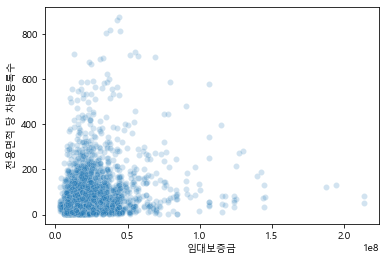

In [49]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

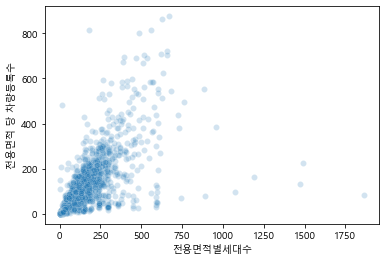

In [50]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [51]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [52]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [53]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

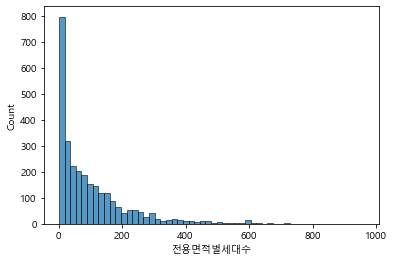

In [54]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

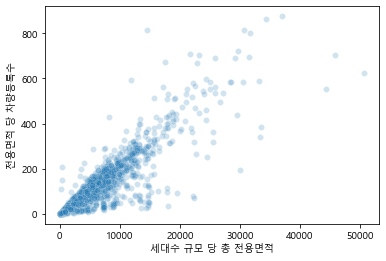

In [55]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [56]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

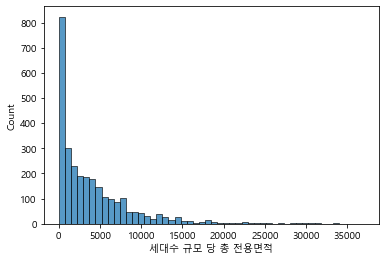

In [57]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='실거주세대수', ylabel='전용면적 당 차량등록수'>

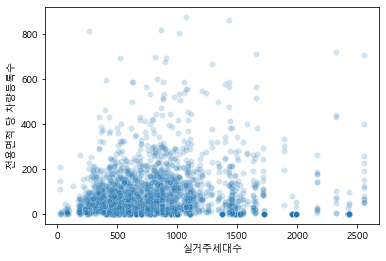

In [58]:
sns.scatterplot(data=train_df, x="실거주세대수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='실거주세대수', ylabel='Count'>

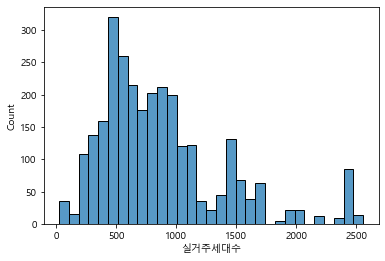

In [59]:
sns.histplot(train_df["실거주세대수"])

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='전용면적 당 차량등록수'>

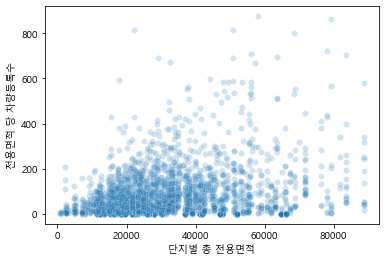

In [60]:
sns.scatterplot(data=train_df, x="단지별 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='Count'>

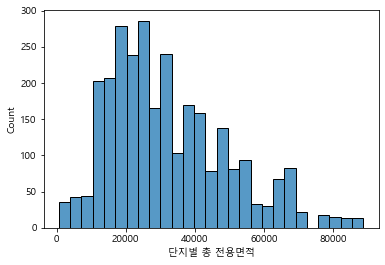

In [61]:
sns.histplot(train_df["단지별 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

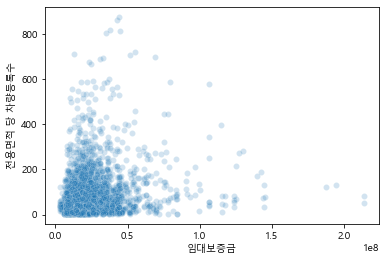

In [62]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [63]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='전용면적 당 차량등록수'>

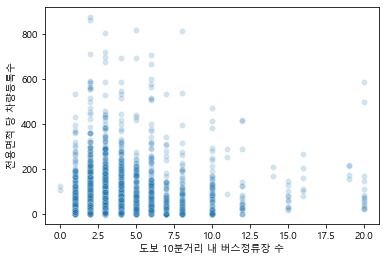

In [64]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 버스정류장 수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='Count'>

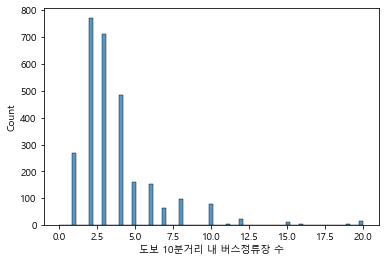

In [65]:
sns.histplot(train_df["도보 10분거리 내 버스정류장 수"])

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='전용면적 당 차량등록수'>

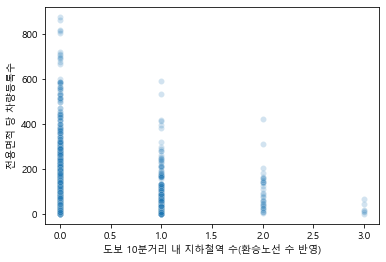

In [66]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 지하철역 수(환승노선 수 반영)", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='Count'>

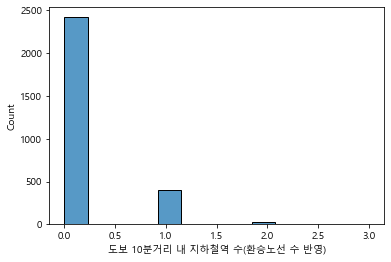

In [67]:
sns.histplot(train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])

<AxesSubplot:xlabel='상가', ylabel='전용면적 당 차량등록수'>

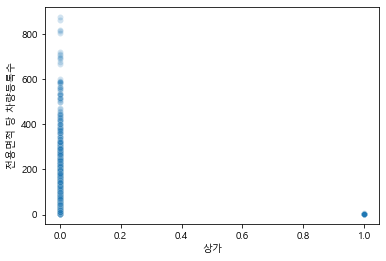

In [68]:
sns.scatterplot(data=train_df, x="상가", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

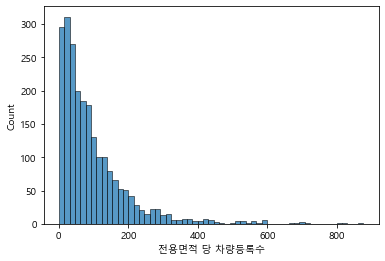

In [69]:
sns.histplot(train_df[train_df["상가"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

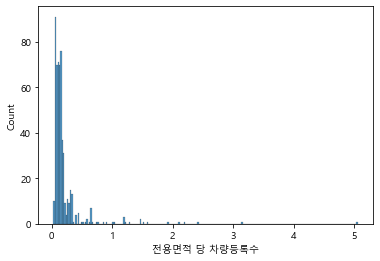

In [70]:
sns.histplot(train_df[train_df["상가"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

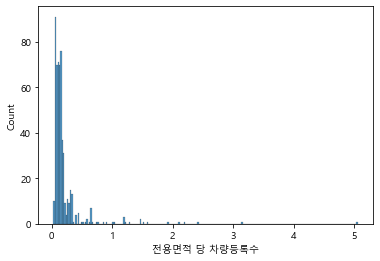

In [71]:
sns.histplot(train_df[train_df["아파트"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

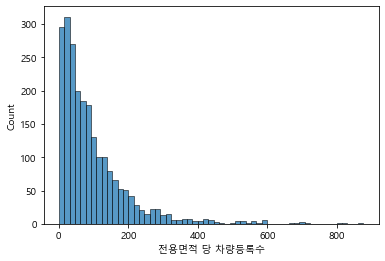

In [72]:
sns.histplot(train_df[train_df["아파트"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

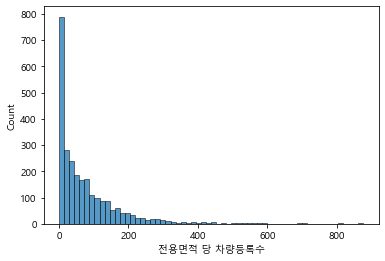

In [73]:
sns.histplot(train_df[train_df["강원도"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='자격유형', ylabel='전용면적 당 차량등록수'>

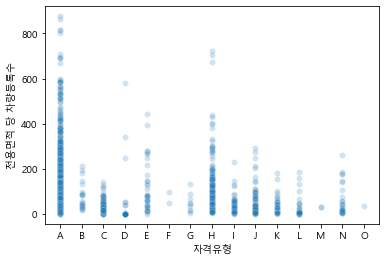

In [74]:
sns.scatterplot(data=train_df, x="자격유형", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='지역', ylabel='전용면적 당 차량등록수'>

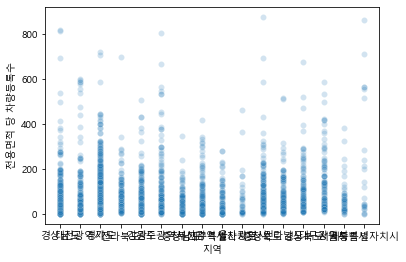

In [75]:
sns.scatterplot(data=train_df, x="지역", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

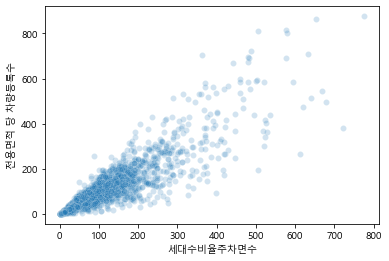

In [76]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [77]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [78]:
correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

# plt.figure(figsize=(20, 16))
# sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [79]:
correlation_df

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,A,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
전용면적 당 차량등록수,-0.008533,0.086054,0.789069,0.121870,0.242554,-0.084184,0.070765,0.384005,0.493973,0.332329,...,0.053883,0.266957,0.017333,0.066608,0.022382,0.250349,-0.088255,-0.375536,NaN,-0.096768
세대수비율주차면수,0.027472,0.021849,0.898431,0.239892,0.157454,-0.085429,0.064952,0.442654,0.415033,0.310859,...,0.017160,0.167297,0.013636,0.055847,0.011636,0.297702,-0.050803,-0.408829,NaN,-0.063255
세대수 규모 당 총 전용면적,0.016870,0.068713,0.925335,0.141603,0.183507,-0.076317,0.072934,0.344077,0.367491,0.302032,...,0.034181,0.203279,0.075896,0.012340,0.010665,0.232106,0.062740,-0.402512,NaN,-0.101567
전용면적별세대수,0.062013,-0.030675,1.000000,0.185720,0.054522,-0.075917,0.064737,0.323313,0.296089,0.195018,...,0.000841,0.054284,0.087283,0.009768,-0.007566,0.218229,0.195092,-0.410776,NaN,-0.032354
등록차량수,0.327042,0.096542,0.296089,0.129783,0.421823,-0.077352,0.111463,0.857204,1.000000,0.346411,...,0.203075,0.390067,-0.059064,0.025368,0.084339,0.263739,-0.089065,-0.449912,NaN,-0.125648
단지내주차면수,0.521607,0.052993,0.323313,0.302376,0.356830,-0.026177,0.079991,1.000000,0.857204,0.263348,...,0.132360,0.230656,-0.075575,0.014964,0.047712,0.288324,-0.083749,-0.409617,NaN,-0.063084
아파트,-0.345064,-0.015352,0.410776,0.249805,0.330165,-0.158689,0.013776,0.409617,0.449912,0.610290,...,0.024554,0.125399,0.051037,0.016063,0.024554,0.611632,0.115392,-1.000000,NaN,0.136663
A,-0.339916,0.118514,0.195018,0.007473,0.122621,-0.096454,0.011556,0.263348,0.346411,1.000000,...,-0.061113,0.205475,0.083628,0.026320,0.040233,0.684438,-0.280724,-0.610290,NaN,-0.340145
공공임대(10년),-0.032233,0.188488,0.054284,-0.066621,0.390556,-0.048931,0.001646,0.230656,0.390067,0.205475,...,-0.012557,1.000000,-0.026101,-0.008215,-0.012557,-0.312798,-0.059013,-0.125399,NaN,-0.069891
국민임대,-0.255778,0.007655,0.218229,0.144856,0.028774,-0.099070,0.018739,0.288324,0.263739,0.684438,...,-0.061247,-0.312798,-0.127309,-0.040067,-0.061247,1.000000,-0.287835,-0.611632,NaN,-0.340893


In [80]:
# X_train & X_test 셋 선택

# ["상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
#  "전용면적 당 차량등록수", "총세대수"]

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [81]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [82]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [83]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
8,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2948,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2949,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2950,114,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [84]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

In [85]:
X_train_df_log.to_csv("X_train_df_log.csv", index=False)
X_test_df_log.to_csv("X_test_df_log.csv", index=False)
y_train_df_log.to_csv("y_train_df.csv", index=False)

### Linear Regression 모델 평가

In [86]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor


In [87]:
X_train_df_log.shape, X_test_df_log.shape, y_train_df_log.shape

((2854, 48), (1008, 48), (2854,))

In [88]:
params = {"alpha": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
ridge_model = Ridge()

grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1,
                                   1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40,
                                   50]},
             scoring='neg_mean_absolute_error')

In [89]:
grid_model.best_params_

{'alpha': 30}

In [90]:
best_ridge = grid_model.best_estimator_
best_ridge

Ridge(alpha=30)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = best_ridge.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.716942200737751

In [107]:
# XGBoost & LGBM 기본 모델 테스트

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

lgbm_reg.fit(X_train, y_train)
pred = lgbm_reg.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

12.219170996774032

In [109]:
lgbm_reg.feature_importances_

array([225, 576, 498,  33, 222,  27,   0,  28,   0,  30,   0,   0,  23,
        10,  18,   0,   0,   0,   2,   0, 416,  14,  54,  50,  32,  22,
        21,  63,  27,   0,  16,   9,  13,   5,   8,  14,   0, 477,   0,
        20,   1,   0,   0,  31,   9,   0,   0,   6])

In [108]:
xgb_reg.fit(X_train, y_train)
pred = xgb_reg.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

10.646295686451735

In [110]:
xgb_reg.feature_importances_

array([7.5339898e-04, 2.7478088e-03, 1.5738105e-03, 2.0456545e-03,
       2.0147057e-03, 1.6598722e-03, 7.8659476e-04, 9.6744172e-02,
       0.0000000e+00, 7.8073461e-03, 0.0000000e+00, 1.9194720e-03,
       1.0059761e-03, 7.7787379e-04, 7.6713194e-03, 8.8059553e-04,
       4.4289278e-04, 1.2131102e-07, 5.3089508e-04, 0.0000000e+00,
       7.2605288e-01, 2.5947622e-03, 1.8834678e-03, 3.2393865e-03,
       7.1073198e-03, 4.1287318e-03, 3.7407703e-03, 5.3209295e-03,
       5.7078111e-03, 1.0189973e-03, 2.3331377e-03, 2.0587954e-03,
       3.5850191e-03, 7.4304338e-04, 3.0829867e-03, 2.6869769e-03,
       0.0000000e+00, 7.2031997e-02, 0.0000000e+00, 1.3269639e-02,
       4.6457024e-03, 1.0627109e-03, 0.0000000e+00, 2.1857910e-03,
       9.2726527e-04, 0.0000000e+00, 0.0000000e+00, 1.2293084e-03],
      dtype=float32)

In [112]:
params = {"n_estimators": [100, 200, 500, 1000],
          "max_depth": [5, 7, 10, 12, 15, 20],
          "learning_rate": [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]}

grid_search = GridSearchCV(xgb_reg, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
     

In [114]:
xgb_best = grid_search.best_estimator_
pred =  xgb_best.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

9.82246444652664

In [117]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}

In [118]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=1000)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

9.82246444652664

In [92]:
# # 릿지 모델 예측

# ridge_model = Ridge(alpha=30)
# ridge_model.fit(X_train_df_log, y_train_df_log)
# pred = ridge_model.predict(X_test_df_log)
# pred = np.expm1(pred)

# result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub_df = sub.merge(final_pred, how="left")
# sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
# sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# # sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

# sub_df

In [93]:
# importance = ridge_model.coef_
# feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(20, 12))
# sns.barplot(x=feature_importance, y=feature_importance.index)
# plt.show()

In [94]:
cat_reg = CatBoostRegressor()

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7666323	total: 147ms	remaining: 2m 27s
1:	learn: 1.6949588	total: 149ms	remaining: 1m 14s
2:	learn: 1.6282127	total: 151ms	remaining: 50.1s
3:	learn: 1.5617337	total: 152ms	remaining: 37.9s
4:	learn: 1.5006612	total: 153ms	remaining: 30.5s
5:	learn: 1.4393472	total: 155ms	remaining: 25.6s
6:	learn: 1.3816965	total: 156ms	remaining: 22.2s
7:	learn: 1.3295461	total: 158ms	remaining: 19.6s
8:	learn: 1.2757298	total: 159ms	remaining: 17.5s
9:	learn: 1.2260460	total: 160ms	remaining: 15.9s
10:	learn: 1.1799607	total: 162ms	remaining: 14.5s
11:	learn: 1.1340970	total: 163ms	remaining: 13.4s
12:	learn: 1.0905202	total: 164ms	remaining: 12.5s
13:	learn: 1.0480217	total: 165ms	remaining: 11.7s
14:	learn: 1.0092599	total: 166ms	remaining: 10.9s
15:	learn: 0.9705941	total: 168ms	remaining: 10.3s
16:	learn: 0.9348442	total: 169ms	remaining: 9.75s
17:	learn: 0.8998656	total: 170ms	remaining: 9.26s
18:	learn: 0.8689824	total: 171ms	remaining: 8.83s
19:	learn:

160:	learn: 0.2142672	total: 349ms	remaining: 1.82s
161:	learn: 0.2140486	total: 351ms	remaining: 1.81s
162:	learn: 0.2137548	total: 352ms	remaining: 1.81s
163:	learn: 0.2134949	total: 353ms	remaining: 1.8s
164:	learn: 0.2133005	total: 354ms	remaining: 1.79s
165:	learn: 0.2128747	total: 356ms	remaining: 1.79s
166:	learn: 0.2126134	total: 357ms	remaining: 1.78s
167:	learn: 0.2122357	total: 358ms	remaining: 1.77s
168:	learn: 0.2115192	total: 359ms	remaining: 1.77s
169:	learn: 0.2109973	total: 360ms	remaining: 1.76s
170:	learn: 0.2104804	total: 362ms	remaining: 1.75s
171:	learn: 0.2102030	total: 363ms	remaining: 1.75s
172:	learn: 0.2099043	total: 364ms	remaining: 1.74s
173:	learn: 0.2096131	total: 365ms	remaining: 1.73s
174:	learn: 0.2092061	total: 367ms	remaining: 1.73s
175:	learn: 0.2086004	total: 368ms	remaining: 1.72s
176:	learn: 0.2083158	total: 369ms	remaining: 1.72s
177:	learn: 0.2080350	total: 370ms	remaining: 1.71s
178:	learn: 0.2078849	total: 371ms	remaining: 1.7s
179:	learn: 0.

441:	learn: 0.1535409	total: 687ms	remaining: 867ms
442:	learn: 0.1533229	total: 688ms	remaining: 865ms
443:	learn: 0.1532732	total: 689ms	remaining: 863ms
444:	learn: 0.1532062	total: 691ms	remaining: 861ms
445:	learn: 0.1531097	total: 692ms	remaining: 859ms
446:	learn: 0.1529217	total: 693ms	remaining: 857ms
447:	learn: 0.1527130	total: 694ms	remaining: 855ms
448:	learn: 0.1526327	total: 695ms	remaining: 853ms
449:	learn: 0.1523537	total: 697ms	remaining: 852ms
450:	learn: 0.1522048	total: 698ms	remaining: 850ms
451:	learn: 0.1518374	total: 699ms	remaining: 848ms
452:	learn: 0.1518005	total: 700ms	remaining: 846ms
453:	learn: 0.1517078	total: 702ms	remaining: 844ms
454:	learn: 0.1516088	total: 703ms	remaining: 842ms
455:	learn: 0.1515407	total: 704ms	remaining: 840ms
456:	learn: 0.1514750	total: 705ms	remaining: 838ms
457:	learn: 0.1513194	total: 706ms	remaining: 836ms
458:	learn: 0.1512548	total: 708ms	remaining: 834ms
459:	learn: 0.1509717	total: 709ms	remaining: 832ms
460:	learn: 

718:	learn: 0.1198514	total: 1.02s	remaining: 400ms
719:	learn: 0.1197025	total: 1.02s	remaining: 399ms
720:	learn: 0.1196262	total: 1.02s	remaining: 397ms
721:	learn: 0.1195282	total: 1.03s	remaining: 396ms
722:	learn: 0.1194392	total: 1.03s	remaining: 394ms
723:	learn: 0.1194079	total: 1.03s	remaining: 393ms
724:	learn: 0.1193637	total: 1.03s	remaining: 391ms
725:	learn: 0.1192913	total: 1.03s	remaining: 390ms
726:	learn: 0.1191042	total: 1.03s	remaining: 388ms
727:	learn: 0.1189636	total: 1.03s	remaining: 387ms
728:	learn: 0.1188606	total: 1.03s	remaining: 385ms
729:	learn: 0.1187526	total: 1.04s	remaining: 384ms
730:	learn: 0.1185678	total: 1.04s	remaining: 382ms
731:	learn: 0.1184805	total: 1.04s	remaining: 381ms
732:	learn: 0.1184051	total: 1.04s	remaining: 379ms
733:	learn: 0.1183987	total: 1.04s	remaining: 378ms
734:	learn: 0.1182706	total: 1.04s	remaining: 376ms
735:	learn: 0.1182508	total: 1.04s	remaining: 375ms
736:	learn: 0.1180915	total: 1.05s	remaining: 373ms
737:	learn: 

9.38574738025158

In [111]:
cat_reg.feature_importances_

array([1.21770364e+01, 4.71769112e+00, 5.19256536e+00, 4.32609911e-01,
       1.94337998e+00, 6.14179268e-01, 1.72123882e-02, 1.38815926e+00,
       6.94448789e+00, 1.81136430e-01, 4.62822393e-03, 3.25201573e-02,
       5.67090283e-02, 5.77209215e-02, 1.52413152e-01, 1.69082715e-02,
       1.47926370e-02, 2.83666089e-03, 6.41375619e-03, 1.39579022e-04,
       2.64418884e+01, 5.34764284e-01, 4.76897298e-01, 6.65113834e-01,
       4.07271781e-01, 2.16387174e-01, 1.44193781e-01, 5.81922665e-01,
       2.75883066e-01, 1.66011105e-02, 4.04845224e-02, 1.46469591e-01,
       1.71730547e-01, 9.54423241e-02, 1.04587670e-01, 1.75370882e-01,
       5.86979443e+00, 2.48223523e+01, 1.54941054e-02, 4.78136609e-01,
       3.13079647e-02, 4.27747180e-02, 3.50135015e-04, 2.49412946e+00,
       7.77817092e-01, 7.43410592e-01, 0.00000000e+00, 2.75883342e-01])

In [95]:
# 릿지 0.5 & LGBM 0.5 조합 -> 12.3456 Score: 93.5424 (인구데이터 추가)
# 릿지 1.0 -> 14.9751 Score: 95.6543 (인구데이터 X)

# 릿지 0.9 & CatBoost 0.1 조합 -> 14.18295
# 릿지 0.8 & CatBoost 0.2 조합 -> 13.4380
# 릿지 0.7 & CatBoost 0.3 조합 -> 12.7728
# 릿지 0.6 & CatBoost 0.4 조합 -> 12.1470
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6074

# 릿지 alpha=50, 값으로 예측!!! 결과
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6044
# 릿지 0.4 & CatBoost 0.6 조합 -> 11.0139
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.5106

# 릿지 alpha=40,값으로 예측!! 결과
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.4283
# 릿지 0.4 & CatBoost 0.6 조합 -> 10.9511

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7660153	total: 1.98ms	remaining: 1.98s
1:	learn: 1.6939579	total: 3.71ms	remaining: 1.85s
2:	learn: 1.6270559	total: 5.24ms	remaining: 1.74s
3:	learn: 1.5630121	total: 6.71ms	remaining: 1.67s
4:	learn: 1.4996392	total: 8.11ms	remaining: 1.61s
5:	learn: 1.4397555	total: 9.41ms	remaining: 1.56s
6:	learn: 1.3823125	total: 10.6ms	remaining: 1.5s
7:	learn: 1.3266946	total: 11.8ms	remaining: 1.46s
8:	learn: 1.2751619	total: 13ms	remaining: 1.43s
9:	learn: 1.2257300	total: 14.2ms	remaining: 1.4s
10:	learn: 1.1793590	total: 15.4ms	remaining: 1.39s
11:	learn: 1.1361100	total: 16.6ms	remaining: 1.37s
12:	learn: 1.0919931	total: 17.9ms	remaining: 1.36s
13:	learn: 1.0510757	total: 19.1ms	remaining: 1.34s
14:	learn: 1.0102971	total: 20.4ms	remaining: 1.34s
15:	learn: 0.9712882	total: 21.5ms	remaining: 1.32s
16:	learn: 0.9344677	total: 22.7ms	remaining: 1.31s
17:	learn: 0.8992607	total: 24ms	remaining: 1.31s
18:	learn: 0.8657534	total: 25.1ms	remaining: 1.3s


272:	learn: 0.1852628	total: 333ms	remaining: 887ms
273:	learn: 0.1846514	total: 334ms	remaining: 886ms
274:	learn: 0.1845527	total: 336ms	remaining: 885ms
275:	learn: 0.1843196	total: 337ms	remaining: 883ms
276:	learn: 0.1841035	total: 338ms	remaining: 882ms
277:	learn: 0.1838454	total: 339ms	remaining: 881ms
278:	learn: 0.1836143	total: 340ms	remaining: 880ms
279:	learn: 0.1833478	total: 342ms	remaining: 879ms
280:	learn: 0.1830930	total: 343ms	remaining: 878ms
281:	learn: 0.1828911	total: 344ms	remaining: 876ms
282:	learn: 0.1827726	total: 346ms	remaining: 876ms
283:	learn: 0.1825828	total: 347ms	remaining: 875ms
284:	learn: 0.1823092	total: 348ms	remaining: 873ms
285:	learn: 0.1821230	total: 349ms	remaining: 872ms
286:	learn: 0.1818860	total: 351ms	remaining: 871ms
287:	learn: 0.1818072	total: 352ms	remaining: 870ms
288:	learn: 0.1814927	total: 353ms	remaining: 868ms
289:	learn: 0.1814219	total: 354ms	remaining: 867ms
290:	learn: 0.1812356	total: 355ms	remaining: 866ms
291:	learn: 

555:	learn: 0.1391386	total: 672ms	remaining: 536ms
556:	learn: 0.1389478	total: 673ms	remaining: 535ms
557:	learn: 0.1386917	total: 674ms	remaining: 534ms
558:	learn: 0.1385474	total: 675ms	remaining: 533ms
559:	learn: 0.1384166	total: 677ms	remaining: 532ms
560:	learn: 0.1383471	total: 678ms	remaining: 530ms
561:	learn: 0.1380937	total: 679ms	remaining: 529ms
562:	learn: 0.1380228	total: 680ms	remaining: 528ms
563:	learn: 0.1379066	total: 682ms	remaining: 527ms
564:	learn: 0.1377299	total: 683ms	remaining: 526ms
565:	learn: 0.1376832	total: 684ms	remaining: 524ms
566:	learn: 0.1374821	total: 685ms	remaining: 523ms
567:	learn: 0.1374634	total: 686ms	remaining: 522ms
568:	learn: 0.1373365	total: 688ms	remaining: 521ms
569:	learn: 0.1372577	total: 689ms	remaining: 520ms
570:	learn: 0.1370896	total: 690ms	remaining: 519ms
571:	learn: 0.1369917	total: 692ms	remaining: 517ms
572:	learn: 0.1369342	total: 693ms	remaining: 516ms
573:	learn: 0.1366818	total: 694ms	remaining: 515ms
574:	learn: 

833:	learn: 0.1093124	total: 1.01s	remaining: 201ms
834:	learn: 0.1092444	total: 1.01s	remaining: 200ms
835:	learn: 0.1091433	total: 1.01s	remaining: 198ms
836:	learn: 0.1090467	total: 1.01s	remaining: 197ms
837:	learn: 0.1089729	total: 1.01s	remaining: 196ms
838:	learn: 0.1088830	total: 1.01s	remaining: 195ms
839:	learn: 0.1088008	total: 1.02s	remaining: 194ms
840:	learn: 0.1087188	total: 1.02s	remaining: 192ms
841:	learn: 0.1086098	total: 1.02s	remaining: 191ms
842:	learn: 0.1085522	total: 1.02s	remaining: 190ms
843:	learn: 0.1084116	total: 1.02s	remaining: 189ms
844:	learn: 0.1083352	total: 1.02s	remaining: 188ms
845:	learn: 0.1081888	total: 1.02s	remaining: 186ms
846:	learn: 0.1080980	total: 1.02s	remaining: 185ms
847:	learn: 0.1080474	total: 1.03s	remaining: 184ms
848:	learn: 0.1079540	total: 1.03s	remaining: 183ms
849:	learn: 0.1078692	total: 1.03s	remaining: 182ms
850:	learn: 0.1077789	total: 1.03s	remaining: 180ms
851:	learn: 0.1077720	total: 1.03s	remaining: 179ms
852:	learn: 

10.850410755854305

In [96]:
# 릿지 (alpha=40) 0.4 & CatBoost 0.6 조합 -> 88.6317475529 , MAE -> 10.9511
# 릿지 (alpha=40) 0.3 & CatBoost 0.7 조합 -> 89.9021750236, MAE -> 10.4283

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
sub_df.to_csv("ridge(0.4)&catboost(0.6)조합_공급유형추가_임대보증금지역예측값적용_0727.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676638	total: 1.91ms	remaining: 1.91s
1:	learn: 1.6932903	total: 3.39ms	remaining: 1.69s
2:	learn: 1.6217559	total: 4.74ms	remaining: 1.57s
3:	learn: 1.5530860	total: 6.12ms	remaining: 1.52s
4:	learn: 1.4871545	total: 7.52ms	remaining: 1.5s
5:	learn: 1.4250644	total: 8.98ms	remaining: 1.49s
6:	learn: 1.3651551	total: 10.3ms	remaining: 1.46s
7:	learn: 1.3099859	total: 11.1ms	remaining: 1.38s
8:	learn: 1.2567135	total: 12.4ms	remaining: 1.37s
9:	learn: 1.2053241	total: 13.7ms	remaining: 1.36s
10:	learn: 1.1561144	total: 15ms	remaining: 1.35s
11:	learn: 1.1085535	total: 16.3ms	remaining: 1.34s
12:	learn: 1.0651810	total: 17.3ms	remaining: 1.31s
13:	learn: 1.0230843	total: 18.7ms	remaining: 1.32s
14:	learn: 0.9826531	total: 20.1ms	remaining: 1.32s
15:	learn: 0.9440812	total: 21.4ms	remaining: 1.32s
16:	learn: 0.9082635	total: 22.8ms	remaining: 1.32s
17:	learn: 0.8740238	total: 24.2ms	remaining: 1.32s
18:	learn: 0.8399272	total: 25.5ms	remaining: 1.

171:	learn: 0.2182682	total: 228ms	remaining: 1.1s
172:	learn: 0.2179817	total: 230ms	remaining: 1.1s
173:	learn: 0.2177151	total: 231ms	remaining: 1.09s
174:	learn: 0.2175111	total: 232ms	remaining: 1.09s
175:	learn: 0.2172383	total: 233ms	remaining: 1.09s
176:	learn: 0.2169313	total: 235ms	remaining: 1.09s
177:	learn: 0.2167346	total: 236ms	remaining: 1.09s
178:	learn: 0.2161636	total: 237ms	remaining: 1.09s
179:	learn: 0.2158037	total: 239ms	remaining: 1.09s
180:	learn: 0.2155486	total: 240ms	remaining: 1.08s
181:	learn: 0.2152673	total: 241ms	remaining: 1.08s
182:	learn: 0.2149069	total: 242ms	remaining: 1.08s
183:	learn: 0.2145422	total: 244ms	remaining: 1.08s
184:	learn: 0.2141409	total: 245ms	remaining: 1.08s
185:	learn: 0.2139806	total: 246ms	remaining: 1.08s
186:	learn: 0.2137467	total: 248ms	remaining: 1.08s
187:	learn: 0.2134848	total: 249ms	remaining: 1.07s
188:	learn: 0.2131459	total: 250ms	remaining: 1.07s
189:	learn: 0.2128794	total: 251ms	remaining: 1.07s
190:	learn: 0.

381:	learn: 0.1675661	total: 497ms	remaining: 804ms
382:	learn: 0.1673982	total: 499ms	remaining: 803ms
383:	learn: 0.1672401	total: 500ms	remaining: 802ms
384:	learn: 0.1670664	total: 501ms	remaining: 801ms
385:	learn: 0.1668128	total: 503ms	remaining: 799ms
386:	learn: 0.1663872	total: 504ms	remaining: 798ms
387:	learn: 0.1661797	total: 505ms	remaining: 797ms
388:	learn: 0.1661164	total: 507ms	remaining: 796ms
389:	learn: 0.1659359	total: 508ms	remaining: 794ms
390:	learn: 0.1657407	total: 509ms	remaining: 793ms
391:	learn: 0.1654766	total: 510ms	remaining: 792ms
392:	learn: 0.1653130	total: 512ms	remaining: 790ms
393:	learn: 0.1651478	total: 513ms	remaining: 789ms
394:	learn: 0.1648774	total: 514ms	remaining: 788ms
395:	learn: 0.1645766	total: 516ms	remaining: 786ms
396:	learn: 0.1644061	total: 517ms	remaining: 785ms
397:	learn: 0.1642052	total: 518ms	remaining: 784ms
398:	learn: 0.1639095	total: 519ms	remaining: 782ms
399:	learn: 0.1637562	total: 521ms	remaining: 781ms
400:	learn: 

565:	learn: 0.1378138	total: 738ms	remaining: 566ms
566:	learn: 0.1377201	total: 739ms	remaining: 565ms
567:	learn: 0.1376047	total: 741ms	remaining: 563ms
568:	learn: 0.1374972	total: 742ms	remaining: 562ms
569:	learn: 0.1374065	total: 743ms	remaining: 561ms
570:	learn: 0.1372355	total: 745ms	remaining: 560ms
571:	learn: 0.1371380	total: 746ms	remaining: 558ms
572:	learn: 0.1370305	total: 747ms	remaining: 557ms
573:	learn: 0.1369178	total: 749ms	remaining: 556ms
574:	learn: 0.1366508	total: 750ms	remaining: 554ms
575:	learn: 0.1363590	total: 751ms	remaining: 553ms
576:	learn: 0.1361916	total: 753ms	remaining: 552ms
577:	learn: 0.1361160	total: 754ms	remaining: 551ms
578:	learn: 0.1360250	total: 756ms	remaining: 549ms
579:	learn: 0.1359598	total: 757ms	remaining: 548ms
580:	learn: 0.1358542	total: 758ms	remaining: 547ms
581:	learn: 0.1358006	total: 759ms	remaining: 545ms
582:	learn: 0.1356483	total: 761ms	remaining: 544ms
583:	learn: 0.1355225	total: 762ms	remaining: 543ms
584:	learn: 

769:	learn: 0.1158667	total: 1.01s	remaining: 301ms
770:	learn: 0.1156748	total: 1.01s	remaining: 299ms
771:	learn: 0.1155676	total: 1.01s	remaining: 298ms
772:	learn: 0.1154409	total: 1.01s	remaining: 297ms
773:	learn: 0.1153737	total: 1.01s	remaining: 296ms
774:	learn: 0.1152896	total: 1.01s	remaining: 294ms
775:	learn: 0.1152234	total: 1.01s	remaining: 293ms
776:	learn: 0.1151787	total: 1.02s	remaining: 292ms
777:	learn: 0.1150961	total: 1.02s	remaining: 291ms
778:	learn: 0.1149292	total: 1.02s	remaining: 289ms
779:	learn: 0.1148930	total: 1.02s	remaining: 288ms
780:	learn: 0.1148006	total: 1.02s	remaining: 287ms
781:	learn: 0.1147643	total: 1.02s	remaining: 286ms
782:	learn: 0.1146912	total: 1.02s	remaining: 284ms
783:	learn: 0.1146586	total: 1.03s	remaining: 283ms
784:	learn: 0.1145763	total: 1.03s	remaining: 282ms
785:	learn: 0.1145110	total: 1.03s	remaining: 281ms
786:	learn: 0.1144373	total: 1.03s	remaining: 279ms
787:	learn: 0.1143822	total: 1.03s	remaining: 278ms
788:	learn: 

947:	learn: 0.1024020	total: 1.25s	remaining: 68.3ms
948:	learn: 0.1023715	total: 1.25s	remaining: 67ms
949:	learn: 0.1023422	total: 1.25s	remaining: 65.7ms
950:	learn: 0.1022683	total: 1.25s	remaining: 64.4ms
951:	learn: 0.1022180	total: 1.25s	remaining: 63.1ms
952:	learn: 0.1020631	total: 1.25s	remaining: 61.7ms
953:	learn: 0.1020291	total: 1.25s	remaining: 60.4ms
954:	learn: 0.1020015	total: 1.25s	remaining: 59.1ms
955:	learn: 0.1019465	total: 1.25s	remaining: 57.8ms
956:	learn: 0.1018140	total: 1.26s	remaining: 56.5ms
957:	learn: 0.1017522	total: 1.26s	remaining: 55.2ms
958:	learn: 0.1017287	total: 1.26s	remaining: 53.9ms
959:	learn: 0.1017133	total: 1.26s	remaining: 52.6ms
960:	learn: 0.1016613	total: 1.26s	remaining: 51.3ms
961:	learn: 0.1015584	total: 1.26s	remaining: 49.9ms
962:	learn: 0.1015185	total: 1.26s	remaining: 48.6ms
963:	learn: 0.1014869	total: 1.27s	remaining: 47.3ms
964:	learn: 0.1014515	total: 1.27s	remaining: 46ms
965:	learn: 0.1014062	total: 1.27s	remaining: 44.7

,code,num
0,C1072,716.828954
1,C1128,1317.521284
2,C1456,498.900406
3,C1840,473.037570
4,C1332,1194.464876
...,...,...
145,C2456,238.440204
146,C1266,414.482352
147,C2152,26.190169
148,C1267,342.231039


In [97]:
from sklearn.linear_model import Lasso


params = {"alpha": [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
lasso_model = Lasso()


lasso_grid = GridSearchCV(lasso_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
lasso_grid.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03,
                                   0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15,
                                   20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error')

In [98]:
lasso_grid.best_params_

{'alpha': 0.001}

In [99]:
lasso_grid.best_estimator_.coef_

array([ 0.01841803, -0.04826869,  0.2036506 , -0.04053434,  0.00679913,
        0.05476811,  0.        , -0.44141234,  0.25967366, -0.31411567,
       -0.        , -0.        ,  0.02426457,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.61561323,  0.        , -0.06028042, -0.11501622,  0.18402428,
        0.11944266,  0.08506094, -0.19936287, -0.11070919,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.00686454, -0.        ,
       -0.        , -0.        ,  0.31677327,  0.        ,  0.06655938,
       -0.        ,  0.        , -0.        ,  0.        , -0.11195762,
        0.        ,  0.        , -0.30563598])

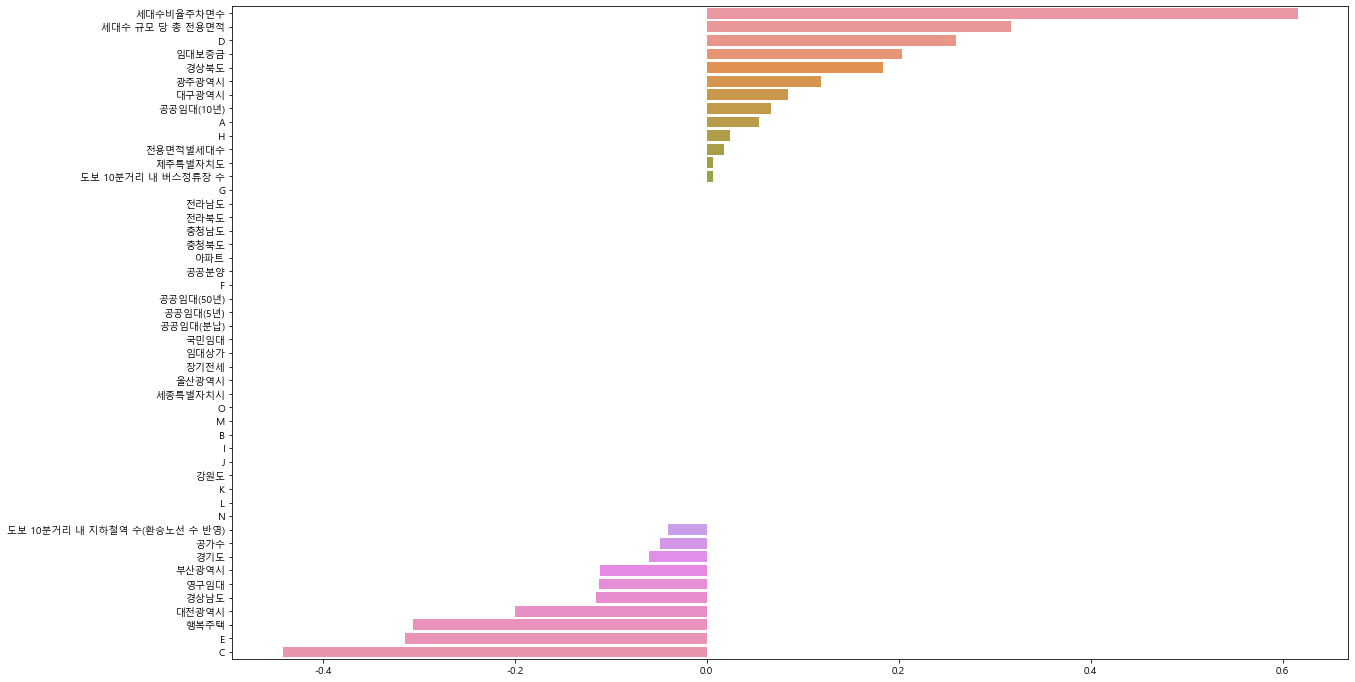

In [100]:
importance = lasso_grid.best_estimator_.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [101]:
lasso_best = lasso_grid.best_estimator_


X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = lasso_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.743851050751406

### Ridge & Lasso & CatBoost 조합 -> 0.2 & 0.2 & 0.6 조합

In [119]:
# MAE 10.6983

X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=1000)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
boosting_pred = (cat_pred * 0.5) + (xgb_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (boosting_pred * 0.6)

mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7660153	total: 1.57ms	remaining: 1.57s
1:	learn: 1.6939579	total: 2.81ms	remaining: 1.4s
2:	learn: 1.6270559	total: 4.01ms	remaining: 1.33s
3:	learn: 1.5630121	total: 5.22ms	remaining: 1.3s
4:	learn: 1.4996392	total: 6.44ms	remaining: 1.28s
5:	learn: 1.4397555	total: 7.64ms	remaining: 1.26s
6:	learn: 1.3823125	total: 8.85ms	remaining: 1.25s
7:	learn: 1.3266946	total: 10ms	remaining: 1.24s
8:	learn: 1.2751619	total: 11.2ms	remaining: 1.24s
9:	learn: 1.2257300	total: 12.4ms	remaining: 1.23s
10:	learn: 1.1793590	total: 13.6ms	remaining: 1.22s
11:	learn: 1.1361100	total: 14.7ms	remaining: 1.21s
12:	learn: 1.0919931	total: 15.9ms	remaining: 1.21s
13:	learn: 1.0510757	total: 17.1ms	remaining: 1.21s
14:	learn: 1.0102971	total: 18.3ms	remaining: 1.2s
15:	learn: 0.9712882	total: 19.5ms	remaining: 1.2s
16:	learn: 0.9344677	total: 20.6ms	remaining: 1.19s
17:	learn: 0.8992607	total: 21.8ms	remaining: 1.19s
18:	learn: 0.8657534	total: 23ms	remaining: 1.19s
1

277:	learn: 0.1838454	total: 330ms	remaining: 856ms
278:	learn: 0.1836143	total: 331ms	remaining: 855ms
279:	learn: 0.1833478	total: 332ms	remaining: 854ms
280:	learn: 0.1830930	total: 333ms	remaining: 853ms
281:	learn: 0.1828911	total: 335ms	remaining: 852ms
282:	learn: 0.1827726	total: 336ms	remaining: 851ms
283:	learn: 0.1825828	total: 337ms	remaining: 849ms
284:	learn: 0.1823092	total: 338ms	remaining: 848ms
285:	learn: 0.1821230	total: 339ms	remaining: 847ms
286:	learn: 0.1818860	total: 341ms	remaining: 846ms
287:	learn: 0.1818072	total: 342ms	remaining: 845ms
288:	learn: 0.1814927	total: 343ms	remaining: 844ms
289:	learn: 0.1814219	total: 344ms	remaining: 843ms
290:	learn: 0.1812356	total: 346ms	remaining: 842ms
291:	learn: 0.1811817	total: 347ms	remaining: 841ms
292:	learn: 0.1809003	total: 348ms	remaining: 840ms
293:	learn: 0.1806889	total: 349ms	remaining: 838ms
294:	learn: 0.1804842	total: 350ms	remaining: 837ms
295:	learn: 0.1802346	total: 352ms	remaining: 836ms
296:	learn: 

562:	learn: 0.1380228	total: 668ms	remaining: 518ms
563:	learn: 0.1379066	total: 669ms	remaining: 517ms
564:	learn: 0.1377299	total: 670ms	remaining: 516ms
565:	learn: 0.1376832	total: 671ms	remaining: 515ms
566:	learn: 0.1374821	total: 673ms	remaining: 514ms
567:	learn: 0.1374634	total: 674ms	remaining: 513ms
568:	learn: 0.1373365	total: 675ms	remaining: 511ms
569:	learn: 0.1372577	total: 676ms	remaining: 510ms
570:	learn: 0.1370896	total: 678ms	remaining: 509ms
571:	learn: 0.1369917	total: 679ms	remaining: 508ms
572:	learn: 0.1369342	total: 680ms	remaining: 507ms
573:	learn: 0.1366818	total: 681ms	remaining: 506ms
574:	learn: 0.1366265	total: 683ms	remaining: 504ms
575:	learn: 0.1365386	total: 684ms	remaining: 503ms
576:	learn: 0.1364118	total: 685ms	remaining: 502ms
577:	learn: 0.1363553	total: 686ms	remaining: 501ms
578:	learn: 0.1360642	total: 687ms	remaining: 500ms
579:	learn: 0.1359534	total: 689ms	remaining: 499ms
580:	learn: 0.1358605	total: 690ms	remaining: 497ms
581:	learn: 

841:	learn: 0.1086098	total: 1s	remaining: 188ms
842:	learn: 0.1085522	total: 1s	remaining: 187ms
843:	learn: 0.1084116	total: 1.01s	remaining: 186ms
844:	learn: 0.1083352	total: 1.01s	remaining: 185ms
845:	learn: 0.1081888	total: 1.01s	remaining: 184ms
846:	learn: 0.1080980	total: 1.01s	remaining: 182ms
847:	learn: 0.1080474	total: 1.01s	remaining: 181ms
848:	learn: 0.1079540	total: 1.01s	remaining: 180ms
849:	learn: 0.1078692	total: 1.01s	remaining: 179ms
850:	learn: 0.1077789	total: 1.01s	remaining: 178ms
851:	learn: 0.1077720	total: 1.01s	remaining: 176ms
852:	learn: 0.1076921	total: 1.02s	remaining: 175ms
853:	learn: 0.1076468	total: 1.02s	remaining: 174ms
854:	learn: 0.1075752	total: 1.02s	remaining: 173ms
855:	learn: 0.1074339	total: 1.02s	remaining: 172ms
856:	learn: 0.1073849	total: 1.02s	remaining: 170ms
857:	learn: 0.1073336	total: 1.02s	remaining: 169ms
858:	learn: 0.1072779	total: 1.02s	remaining: 168ms
859:	learn: 0.1072338	total: 1.02s	remaining: 167ms
860:	learn: 0.1071

10.698382610352915

In [121]:
# ridge(0.2) lasso(0.2) catboost(0.6) 조합 -> 87.2708898934, MAE -> 10.8230

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=1000)
xgb.fit(X_train_df_log, y_train_df_log)
xgb_pred = xgb.predict(X_test_df_log)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
boosting_pred = (cat_pred * 0.5) + (xgb_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (boosting_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.3) & xgboost(0.3)조합_공급유형추가_임대보증금예측값적용_0730.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676638	total: 1.69ms	remaining: 1.69s
1:	learn: 1.6932903	total: 2.99ms	remaining: 1.49s
2:	learn: 1.6217559	total: 4.2ms	remaining: 1.4s
3:	learn: 1.5530860	total: 5.49ms	remaining: 1.37s
4:	learn: 1.4871545	total: 6.74ms	remaining: 1.34s
5:	learn: 1.4250644	total: 8.01ms	remaining: 1.33s
6:	learn: 1.3651551	total: 9.29ms	remaining: 1.32s
7:	learn: 1.3099859	total: 10ms	remaining: 1.25s
8:	learn: 1.2567135	total: 11.3ms	remaining: 1.24s
9:	learn: 1.2053241	total: 12.6ms	remaining: 1.25s
10:	learn: 1.1561144	total: 13.9ms	remaining: 1.25s
11:	learn: 1.1085535	total: 15.1ms	remaining: 1.25s
12:	learn: 1.0651810	total: 16.1ms	remaining: 1.22s
13:	learn: 1.0230843	total: 17.4ms	remaining: 1.23s
14:	learn: 0.9826531	total: 18.7ms	remaining: 1.23s
15:	learn: 0.9440812	total: 20ms	remaining: 1.23s
16:	learn: 0.9082635	total: 21.2ms	remaining: 1.23s
17:	learn: 0.8740238	total: 22.5ms	remaining: 1.23s
18:	learn: 0.8399272	total: 23.8ms	remaining: 1.23s

268:	learn: 0.1879740	total: 340ms	remaining: 923ms
269:	learn: 0.1877491	total: 341ms	remaining: 921ms
270:	learn: 0.1874045	total: 342ms	remaining: 920ms
271:	learn: 0.1873353	total: 343ms	remaining: 919ms
272:	learn: 0.1871226	total: 345ms	remaining: 918ms
273:	learn: 0.1866480	total: 346ms	remaining: 916ms
274:	learn: 0.1866036	total: 347ms	remaining: 915ms
275:	learn: 0.1864194	total: 348ms	remaining: 914ms
276:	learn: 0.1861080	total: 350ms	remaining: 913ms
277:	learn: 0.1860614	total: 351ms	remaining: 911ms
278:	learn: 0.1857815	total: 352ms	remaining: 910ms
279:	learn: 0.1854374	total: 354ms	remaining: 909ms
280:	learn: 0.1851806	total: 355ms	remaining: 908ms
281:	learn: 0.1849519	total: 356ms	remaining: 907ms
282:	learn: 0.1846893	total: 358ms	remaining: 906ms
283:	learn: 0.1843829	total: 359ms	remaining: 905ms
284:	learn: 0.1841874	total: 360ms	remaining: 903ms
285:	learn: 0.1839192	total: 361ms	remaining: 902ms
286:	learn: 0.1835498	total: 363ms	remaining: 901ms
287:	learn: 

537:	learn: 0.1411119	total: 680ms	remaining: 584ms
538:	learn: 0.1409656	total: 681ms	remaining: 583ms
539:	learn: 0.1408933	total: 683ms	remaining: 581ms
540:	learn: 0.1407943	total: 684ms	remaining: 580ms
541:	learn: 0.1405534	total: 685ms	remaining: 579ms
542:	learn: 0.1404531	total: 686ms	remaining: 578ms
543:	learn: 0.1404020	total: 688ms	remaining: 577ms
544:	learn: 0.1403244	total: 689ms	remaining: 575ms
545:	learn: 0.1402083	total: 690ms	remaining: 574ms
546:	learn: 0.1400976	total: 692ms	remaining: 573ms
547:	learn: 0.1399984	total: 693ms	remaining: 572ms
548:	learn: 0.1398519	total: 695ms	remaining: 571ms
549:	learn: 0.1398168	total: 696ms	remaining: 569ms
550:	learn: 0.1397916	total: 697ms	remaining: 568ms
551:	learn: 0.1397408	total: 698ms	remaining: 567ms
552:	learn: 0.1395531	total: 700ms	remaining: 565ms
553:	learn: 0.1393481	total: 701ms	remaining: 564ms
554:	learn: 0.1392514	total: 702ms	remaining: 563ms
555:	learn: 0.1389186	total: 703ms	remaining: 562ms
556:	learn: 

802:	learn: 0.1132708	total: 1.02s	remaining: 250ms
803:	learn: 0.1132113	total: 1.02s	remaining: 249ms
804:	learn: 0.1131594	total: 1.02s	remaining: 248ms
805:	learn: 0.1131035	total: 1.02s	remaining: 246ms
806:	learn: 0.1130337	total: 1.02s	remaining: 245ms
807:	learn: 0.1129216	total: 1.03s	remaining: 244ms
808:	learn: 0.1128512	total: 1.03s	remaining: 243ms
809:	learn: 0.1127932	total: 1.03s	remaining: 242ms
810:	learn: 0.1127340	total: 1.03s	remaining: 240ms
811:	learn: 0.1126263	total: 1.03s	remaining: 239ms
812:	learn: 0.1125939	total: 1.03s	remaining: 238ms
813:	learn: 0.1125327	total: 1.03s	remaining: 237ms
814:	learn: 0.1124989	total: 1.04s	remaining: 235ms
815:	learn: 0.1123885	total: 1.04s	remaining: 234ms
816:	learn: 0.1123576	total: 1.04s	remaining: 233ms
817:	learn: 0.1122485	total: 1.04s	remaining: 232ms
818:	learn: 0.1121357	total: 1.04s	remaining: 230ms
819:	learn: 0.1120379	total: 1.04s	remaining: 229ms
820:	learn: 0.1120073	total: 1.04s	remaining: 228ms
821:	learn: 

,code,num
0,C1072,708.284406
1,C1128,1336.210228
2,C1456,525.935023
3,C1840,470.705693
4,C1332,1175.519123
...,...,...
145,C2456,241.817142
146,C1266,389.813477
147,C2152,28.457771
148,C1267,336.811931
